In [1]:
import os
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

DATASET_PATH = '/home/alk/aau/datasets'
SVEBOLLE_PATH = os.path.join(DATASET_PATH, 'Svebolle')
SVEBOLLE_CSV = 'LORA_data.csv'

def load_data(path, csv_file, sep=','):
    "return DataFrame with data from dataset"
    csv_path = os.path.join(path, csv_file)
    return pd.read_csv(csv_path, sep) # sep by default is comma

In [2]:
df = load_data(SVEBOLLE_PATH, SVEBOLLE_CSV, sep=';')

In [3]:
# make RSSI numerical value
df['RSSI'] = [x.replace(',', '.') for x in df.RSSI]
# missing values will be interpreted as Nan
df['RSSI'] = pd.to_numeric(df.RSSI, errors='coerce')

In [4]:
# fix code rate column
df.rename(columns={' 4/5':'codeRate'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689396 entries, 0 to 689395
Data columns (total 14 columns):
Time          689396 non-null object
DevAddr       689276 non-null object
Freq          689396 non-null int64
Chan          689396 non-null int64
BW            689396 non-null int64
SPF           689396 non-null int64
RSSI          689396 non-null float64
SNR           689396 non-null float64
codeRate      689396 non-null object
dataRate      689396 non-null object
crcStatus     689396 non-null int64
mType         689396 non-null object
macPayload    689396 non-null object
_id           689396 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 73.6+ MB


In [5]:
df['codeRate'] = [x.replace(' ', '') for x in df.codeRate]

In [6]:
df['codeRate'] = [0.8 for x in df.codeRate if x=='4/5']

In [7]:
df['codeRate'].head()

0    0.8
1    0.8
2    0.8
3    0.8
4    0.8
Name: codeRate, dtype: float64

In [8]:
df.dataRate = df.SPF * df.BW * df.codeRate / (2**df.SPF) * 1000

In [9]:
df.Freq = df.Freq / 10**6

In [10]:
df['macPayloadLen'] = df.macPayload.str.len() * 4

In [11]:
df.head()

,Time,DevAddr,Freq,Chan,BW,SPF,RSSI,SNR,codeRate,dataRate,crcStatus,mType,macPayload,_id,macPayloadLen
0,2017-01-02 12:08:27.788000,000013c1,868.1,0,125,7,-120.0,-1.0,0.8,5468.75,1,Confirmed Data Up,c1130000804605039977d43d70b12724eea946c5a41f42...,586a34acb5866106ea976eb5,716
1,2017-01-02 12:08:29.196000,000013b8,868.5,2,125,7,-58.0,6.5,0.8,5468.75,1,Confirmed Data Up,b813000000142b0352619fc9a89e0e561d060ca3ac29e5...,586a34aeb5866106ea976eb6,492
2,2017-01-02 12:08:44.520000,000013bf,868.3,1,125,7,-118.8,-1.8,0.8,5468.75,1,Confirmed Data Up,bf13000080ba30042ea26888992702442c832fc2c8ac91...,586a34bdb5866106ea976eb7,492
3,2017-01-02 12:08:55.347000,000013bf,868.5,2,125,7,-115.0,1.8,0.8,5468.75,1,Confirmed Data Up,bf13000080bb30030a96702f4ebe2cfe8559765a622344...,586a34c8b5866106ea976eb8,716
4,2017-01-02 12:08:55.346000,000013bf,868.5,2,125,7,-115.0,1.8,0.8,5468.75,1,Confirmed Data Up,bf13000080bb30030a96702f4ebe2cfe8559765a622344...,586a34c8b5866106ea976eb9,716


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689396 entries, 0 to 689395
Data columns (total 15 columns):
Time             689396 non-null object
DevAddr          689276 non-null object
Freq             689396 non-null float64
Chan             689396 non-null int64
BW               689396 non-null int64
SPF              689396 non-null int64
RSSI             689396 non-null float64
SNR              689396 non-null float64
codeRate         689396 non-null float64
dataRate         689396 non-null float64
crcStatus        689396 non-null int64
mType            689396 non-null object
macPayload       689396 non-null object
_id              689396 non-null object
macPayloadLen    689396 non-null int64
dtypes: float64(5), int64(5), object(5)
memory usage: 78.9+ MB


In [13]:
df.SPF.unique()

array([ 7, 12,  8,  9, 11, 10])

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df['SPF']):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]
    
strat_test_set['SPF'].value_counts() / len(strat_test_set)    

7     0.938845
12    0.054395
8     0.003046
9     0.001900
10    0.001385
11    0.000428
Name: SPF, dtype: float64

In [15]:
data = strat_train_set.copy()

Correlation between every pair of attributes using the corr() method:

In [16]:
corr_matrix = data.corr()

In [17]:
corr_matrix['RSSI'].sort_values(ascending=False)

RSSI             1.000000e+00
SNR              8.277945e-01
Freq             4.395959e-01
dataRate         2.285058e-01
macPayloadLen    9.382098e-03
BW               6.779804e-03
codeRate         2.567466e-13
SPF             -2.245127e-01
Chan            -4.391790e-01
crcStatus                 NaN
Name: RSSI, dtype: float64

The correlation coefficient ranges from -1 to 1:
* close to 1 - there is a strong positive correlation
* close to -1 - there is strong negative correlation
* close to zero - no linear correlation

Another way to check for correlation between attributes is scatter_matrix function embedded in Pandas. There is a lot of numerical attributes it is important to interesting ones.

/home/alk/anaconda3/lib/python3.7/site-packages/pandas/plotting/_misc.py:108: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  ax.set_xlim(boundaries_list[j])
/home/alk/anaconda3/lib/python3.7/site-packages/pandas/plotting/_misc.py:109: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  ax.set_ylim(boundaries_list[i])
/home/alk/anaconda3/lib/python3.7/site-packages/pandas/plotting/_misc.py:100: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  ax.set_xlim(boundaries_list[i])


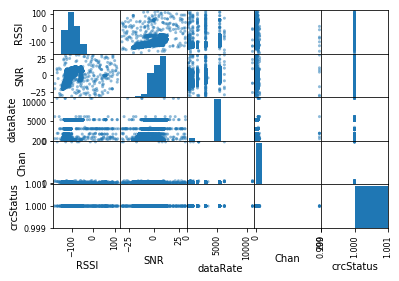

In [18]:
from pandas.plotting import scatter_matrix

attributes = ['RSSI', 'SNR', 'dataRate', 'Chan', 'crcStatus']
scatter_matrix(data[attributes])
plt.show()